_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 7 : Transcriptomics

In [180]:
import numpy as np
import pylab as plt
import pandas as pd
import matplotlib.pyplot as plt

# We recommend using openTSNE for experiments with t-SNE
# https://github.com/pavlin-policar/openTSNE
from openTSNE import TSNE

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2025-06-06 15:49:08CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.30.0

sklearn: 1.6.1

leidenalg : 0.10.2
igraph    : 0.11.8
sklearn   : 1.6.1
numpy     : 2.2.4
openTSNE  : 1.0.2
pandas    : 2.2.3
matplotlib: 3.10.1

Watermark: 2.5.0



In [181]:
plt.style.use("../matplotlib_style.txt")

# Introduction

In this notebook you are going to work with transcriptomics data, in particular single-cell RNA sequencing (scRNA-seq) data from the paper by [Harris et al. (2018)](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387). They recorded the transcriptomes of 3,663 inhibitory cells in the hippocampal area CA1. Their analysis divided these cells into 49 fine-scale clusters coresponding to different cell subtypes. They asigned names to these cluster in a hierarchical fashion according to strongly expressed gene in each clusters. The figure below shows the details of their classification. 

You will first analyze some of the most relevant statistics of UMI gene counts distributions, and afterwards follow the standard pipeline in the field to produce a visualization of the data.

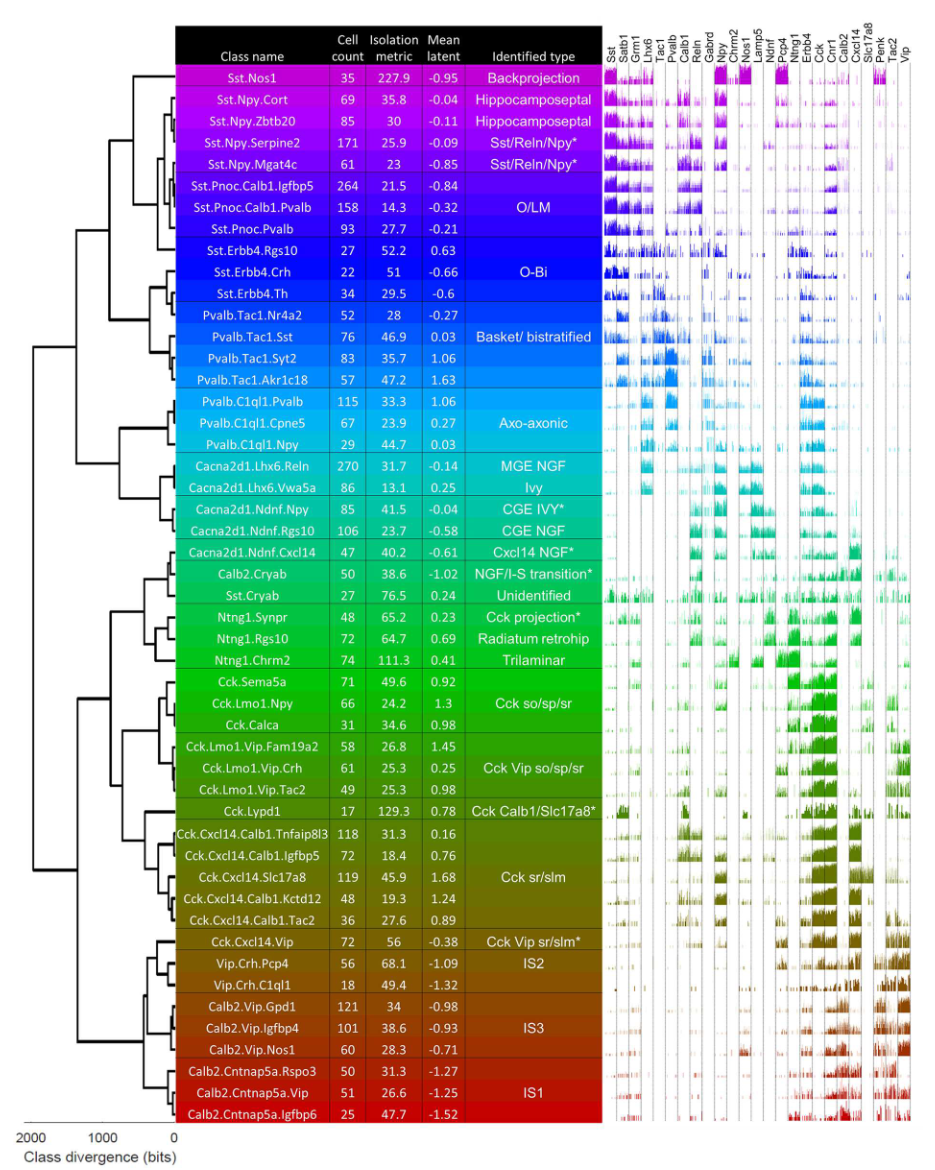

## Load data

Download the data from ILIAS, move it to the `data/` directory and unzip it there.
The read counts can be found in `counts`, with rows corresponding to cells and columns to genes.
The cluster assignments for every individual cell can be found in  `clusters`, along with the colors used in the publication in  `clusterColors`.

In [182]:
# LOAD HARRIS ET AL DATA

# Load gene counts
data = pd.read_csv("../data/nds_cl_7/harris-data/expression.tsv.gz", sep="\t")
genes = data.values[:, 0]
cells = data.columns[1:-1]
counts = data.values[:, 1:-1].transpose().astype("int")
data = []

# Kick out all genes with all counts = 0
genes = genes[counts.sum(axis=0) > 0]
counts = counts[:, counts.sum(axis=0) > 0]
print(counts.shape)

# Load clustering results
data = pd.read_csv("../data/nds_cl_7/harris-data/analysis_results.tsv", sep="\t")
clusterNames, clusters = np.unique(data.values[0, 1:-1], return_inverse=True)

# Load cluster colors
data = pd.read_csv("../data/nds_cl_7/harris-data/colormap.txt", sep="\s+", header=None)
clusterColors = data.values

# Note: the color order needs to be reversed to match the publication
clusterColors = clusterColors[::-1]

# Taken from Figure 1 - we need cluster order to get correct color order
clusterOrder = [
    "Sst.No",
    "Sst.Npy.C",
    "Sst.Npy.Z",
    "Sst.Npy.S",
    "Sst.Npy.M",
    "Sst.Pnoc.Calb1.I",
    "Sst.Pnoc.Calb1.P",
    "Sst.Pnoc.P",
    "Sst.Erbb4.R",
    "Sst.Erbb4.C",
    "Sst.Erbb4.T",
    "Pvalb.Tac1.N",
    "Pvalb.Tac1.Ss",
    "Pvalb.Tac1.Sy",
    "Pvalb.Tac1.A",
    "Pvalb.C1ql1.P",
    "Pvalb.C1ql1.C",
    "Pvalb.C1ql1.N",
    "Cacna2d1.Lhx6.R",
    "Cacna2d1.Lhx6.V",
    "Cacna2d1.Ndnf.N",
    "Cacna2d1.Ndnf.R",
    "Cacna2d1.Ndnf.C",
    "Calb2.Cry",
    "Sst.Cry",
    "Ntng1.S",
    "Ntng1.R",
    "Ntng1.C",
    "Cck.Sema",
    "Cck.Lmo1.N",
    "Cck.Calca",
    "Cck.Lmo1.Vip.F",
    "Cck.Lmo1.Vip.C",
    "Cck.Lmo1.Vip.T",
    "Cck.Ly",
    "Cck.Cxcl14.Calb1.Tn",
    "Cck.Cxcl14.Calb1.I",
    "Cck.Cxcl14.S",
    "Cck.Cxcl14.Calb1.K",
    "Cck.Cxcl14.Calb1.Ta",
    "Cck.Cxcl14.V",
    "Vip.Crh.P",
    "Vip.Crh.C1",
    "Calb2.Vip.G",
    "Calb2.Vip.I",
    "Calb2.Vip.Nos1",
    "Calb2.Cntnap5a.R",
    "Calb2.Cntnap5a.V",
    "Calb2.Cntnap5a.I",
]

reorder = np.zeros(clusterNames.size) * np.nan
for i, c in enumerate(clusterNames):
    for j, k in enumerate(clusterOrder):
        if c[: len(k)] == k:
            reorder[i] = j
            break
clusterColors = clusterColors[reorder.astype(int)]

(3663, 17965)


# Task 1: Data inspection
Before we use t-SNE or any other advanced visualization methods on the data, we first want to have a closer look on the data and plot some statistics. For most of the analysis we will compare the data to a Poisson distribution.

###  1.1. Relationship between expression mean and fraction of zeros
Compute actual and predicted gene expression. The higher the average expression of a gene, the smaller fraction of cells will show a 0 count. Plot the data and explain what you see in the plot.


_(3 pts)_

In [183]:
# ------------------------------------------------------
# Compute actual and predicted gene expression (1 pt)
# ------------------------------------------------------

# Compute the average expression for each gene
mean_expression = counts.mean(axis=0)
# Compute the fraction of zeros for each gene
fraction_zeros = (counts == 0).sum(axis=0) / counts.shape[0]

In [184]:
# Compute the Poisson prediction
# (what is the expected fraction of zeros in a Poisson distribution with a given mean?)
poisson_zero_fraction = np.exp(-mean_expression)  # predicted zero fraction per gene

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/1169264675.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


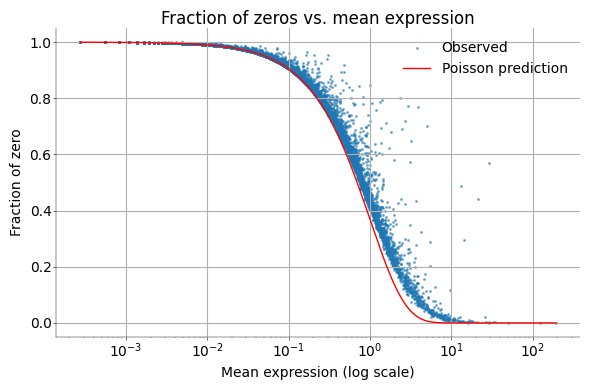

In [185]:
# --------------------------------------------------
# plot the data and the Poisson prediction (1 pt)
# --------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

# Scatter plot of actual data
ax.scatter(mean_expression, fraction_zeros, s=5, alpha=0.5, label="Observed")

# Line plot of Poisson prediction
sorted_means = np.sort(mean_expression)
ax.plot(sorted_means, np.exp(-sorted_means), color="red", label="Poisson prediction")

# Formatting
ax.set_xscale("log")
ax.set_xlabel("Mean expression (log scale)")
ax.set_ylabel("Fraction of zero")
ax.set_title("Fraction of zeros vs. mean expression")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

_Explanation (1 pt)_
...

- For low-expressed genes the observed zeros match Poisson prediction quite closely.
- For medium-to-high expressed genes the blue dots sit above the red line i.e the observed dropout rates are higher than Poisson predicts. Thus the Poisson model underestimates the dropout at moderate to high gene expressions. 
- Possible reasons for this overdispersion might be that gene expression is not just governed by a single rate like we use for our prediction (λ); instead, it might vary across cells due to:
Biological heterogeneity (e.g., gene turned on in one cell type but off in another),
Technical noise (e.g., dropout from low capture efficiency),
Bursting transcription dynamics (on/off stochastic gene activity)

### 1.2. Mean-variance relationship

If the expression follows Poisson distribution, then the mean should be equal to the variance. Plot the mean-variance relationship and interpret the plot.

_(2.5 pts)_

In [186]:
# -------------------------------------------------------------------
# Compute the variance of the expression counts of each gene (0.5 pt)
# -------------------------------------------------------------------

variance_expression = counts.var(axis=0)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/1225000527.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


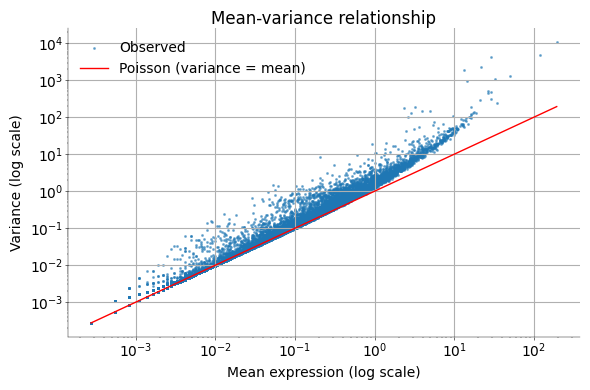

In [187]:
# -------------------------------------------------------------
# Plot the mean-variance relationship on a log-log plot (1 pt)
# Plot the Poisson prediction as a line
# -------------------------------------------------------------

# note: under poisson each gene would follow variance = mean
fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot: each point is a gene
ax.scatter(mean_expression, variance_expression, s=5, alpha=0.5, label="Observed")

# Plot Poisson prediction line (variance = mean)
lims = [mean_expression.min(), mean_expression.max()]
ax.plot(lims, lims, "r", label="Poisson (variance = mean)")

# Log-log scale
ax.set_xscale("log")
ax.set_yscale("log")

# Labels and title
ax.set_xlabel("Mean expression (log scale)")
ax.set_ylabel("Variance (log scale)")
ax.set_title("Mean-variance relationship")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

_Explanation (1 pt)_
...

The plot shows that gene expression variance exceeds the mean for most genes, particularly at higher mean expression levels, the spread of variance increases disproportionately. 
This violates the assumptions of the Poisson model and suggests overdispersion in the data. The result supports the use of more flexible models, such as the negative binomial distribution, as used by Harris et al. (2018), to more accurately capture the underlying variability in such data.

### 1.3. Relationship between the mean and the Fano factor

Compute the Fano factor for each gene and make a scatter plot of expression mean vs. Fano factor in log-log coordinates, and interpret what you see in the plot. If the expression follows the Poisson distribution, then the Fano factor (variance/mean) should be equal to 1 for all genes.

_(2.5 pts)_

In [188]:
# --------------------------------------------
# Compute the Fano factor for each gene (0.5 pt)
# --------------------------------------------

fano = variance_expression / mean_expression

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/3080541825.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


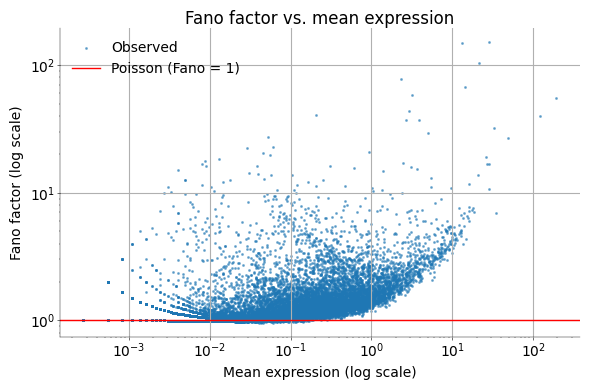

In [189]:
# -------------------------------
# plot fano-factor vs mean (1 pt)
# incl. fano factor
# -------------------------------
# Plot a Poisson prediction as line
# Use the same style of plot as above.

fig, ax = plt.subplots(figsize=(6, 4))

# Scatter plot of Fano factor vs mean
ax.scatter(mean_expression, fano, s=5, alpha=0.5, label="Observed")

# Plot Poisson prediction line: Fano = 1
ax.axhline(1, color="red", label="Poisson (Fano = 1)")

# Log-log scale
ax.set_xscale("log")
ax.set_yscale("log")

# Axis labels and title
ax.set_xlabel("Mean expression (log scale)")
ax.set_ylabel("Fano factor (log scale)")
ax.set_title("Fano factor vs. mean expression")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

_Explanation (1 pt)_
...

Most genes above the red line → variance exceeds the mean, meaning Fano > 1. Most data points lie above the red line, especially beyond  a mean ≈ 0.1.
This indicates overdispersion, just like in the previous mean-variance analysis. The Poisson model underestimates variance.
This reinforces what we observed in the mean-variance plot and zero fraction plot. This pattern of overdispersion highlights that gene expression in single-cell RNA-seq data is influenced by both biological heterogeneity and technical variability.

### 1.4. Histogram of sequencing depths

Different cells have different sequencing depths (sum of counts across all genes) because the efficiency can change from droplet to droplet due to some random expreimental factors. Make a histogram of sequencing depths.

_(1.5 pts)_

In [190]:
# -------------------------------
# Compute sequencing depth (0.5 pt)
# -------------------------------

# Sum of all UMI counts per cell = sequencing depth
sequencing_depth = counts.sum(axis=1)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/568712645.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


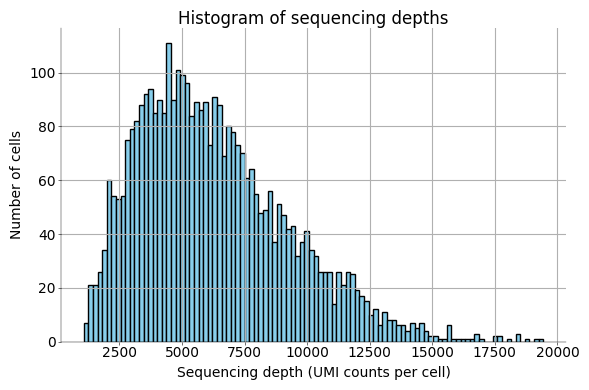

In [191]:
# ------------------------------------------
# Plot histogram of sequencing depths (1 pt)
# ------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))

# Plot histogram of sequencing depths
ax.hist(sequencing_depth, bins=100, color="skyblue", edgecolor="black")

# Formatting
ax.set_xlabel("Sequencing depth (UMI counts per cell)")
ax.set_ylabel("Number of cells")
ax.set_title("Histogram of sequencing depths")
ax.grid(True)
plt.tight_layout()
plt.show()

### 1.5. Fano factors after normalization

Normalize counts by the sequencing depth of each cell and multiply by the median sequencing depth. Then make the same expression vs Fano factor plot as above. After normalization by sequencing depth, Fano factor should be closer to 1 (i.e. variance even more closely following the mean). This can be used for feature selection.

_(2.5 pts)_

In [192]:
# -------------------------------------------------
# compute normalized counts and fano factor (1 pt)
# -------------------------------------------------

# median sequencing depth
median_depth = np.median(sequencing_depth)

# normalized counts per cell by its total count, then scale by median depth
norm_counts = counts / sequencing_depth[:, np.newaxis] * median_depth

# per-gene statistics after normalization
mean_norm = norm_counts.mean(axis=0)
var_norm = norm_counts.var(axis=0)
fano_norm = var_norm / mean_norm

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/2654728508.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


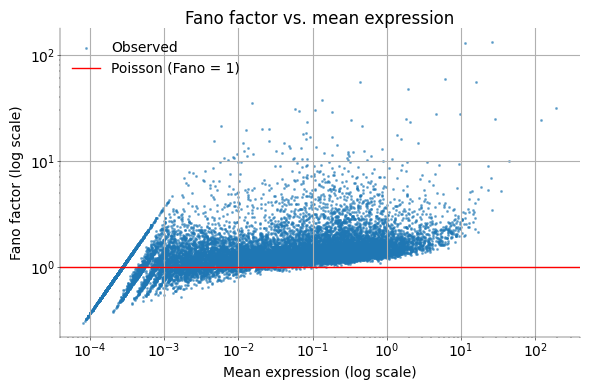

In [193]:
# ----------------------------------------------------------
# plot normalized counts and find the top 10 genes (1 pt)
# hint: keep appropriate axis scaling in mind
# ----------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 4))
# add plot

# Scatter plot of Fano factor vs mean
ax.scatter(mean_norm, fano_norm, s=5, alpha=0.5, label="Observed")

# Plot Poisson prediction line: Fano = 1
ax.axhline(1, color="red", label="Poisson (Fano = 1)")

# Log-log scale
ax.set_xscale("log")
ax.set_yscale("log")

# Axis labels and title
ax.set_xlabel("Mean expression (log scale)")
ax.set_ylabel("Fano factor (log scale)")
ax.set_title("Fano factor vs. mean expression")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [194]:
# --------------------------------------------------------------------
# Find top-10 genes with the highest normalized Fano factor (0.5 pts)
# Print them sorted by the Fano factor starting from the highest
# Gene names are stored in the `genes` array
# --------------------------------------------------------------------

# Get indices of top-10 genes with highest Fano factor
top_indices = np.argsort(fano_norm)[-10:][::-1]  # descending order

# top-10 genes and corresponding Fano factors
print("Top 10 most variable genes after normalization (by Fano factor):")
for i in range(10):
    gene = genes[top_indices[i]]
    fano_value = fano_norm[top_indices[i]]
    print(f"{i + 1}. {gene}: Fano = {fano_value:.2f}")

Top 10 most variable genes after normalization (by Fano factor):
1. Sst: Fano = 131.14
2. Npy: Fano = 128.40
3. Vip: Fano = 59.11
4. Cck: Fano = 55.65
5. Cpne2: Fano = 55.22
6. Pcp4: Fano = 47.65
7. Ptpn23: Fano = 37.25
8. Pdzd9: Fano = 35.06
9. Malat1: Fano = 31.42
10. Armc2: Fano = 30.59


# Task 2: Low dimensional visualization

In this task we will construct a two dimensional visualization of the data. First we will normalize the data with some variance stabilizing transformation and study the effect that different approaches have on the data. Second, we will reduce the dimensionality of the data to a more feasible number of dimensions (e.g. $d=50$) using PCA. And last, we will project the PCA-reduced data to two dimensions using t-SNE.

### 2.1. PCA with and without transformations

Here we look at the influence of variance-stabilizing transformations on PCA. We will focus on the following transformations: 
- Square root (`sqrt(X)`): it is a variance-stabilizing transformation for the Poisson data. 
- Log-transform (`log2(X+1)`): it is also often used in the transcriptomic community. 

We will only work with the most important genes. For that, transform the counts into normalized counts (as above) and select all genes with normalized Fano factor above 3 and remove the rest. We will look at the effect that both transformations have in the PCA-projected data by visualizing the first two components. Interpret qualitatively what you see in the plot and compare the different embeddings making use of the ground truth clusters.

_(3.5 pts)_

In [195]:
# --------------------------------
# Select important genes (0.5 pts)
# --------------------------------

# genes with normalized mean > 0 and Fano > 3
valid = (mean_norm > 0) & (fano_norm > 3)
selected_genes = np.where(valid)[0]

# Subset normalized counts to selected genes
X_sel = norm_counts[:, selected_genes]
print(f"Selected {X_sel.shape[1]} highly variable genes")

Selected 707 highly variable genes


In [196]:
# --------------------------------------
# transform data and apply PCA (1 pt)
# --------------------------------------

from sklearn.decomposition import PCA

# perform PCA

# Raw
X_raw = X_sel

# Square root transform
X_sqrt = np.sqrt(X_sel)

# Log2 transform
X_log = np.log2(X_sel + 1)

# PCA (retain enough PCs for visualization, e.g., 10)
pca = PCA(n_components=50)
PC_raw = pca.fit_transform(X_raw)
PC_sqrt = pca.fit_transform(X_sqrt)
PC_log = pca.fit_transform(X_log)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/3917697553.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


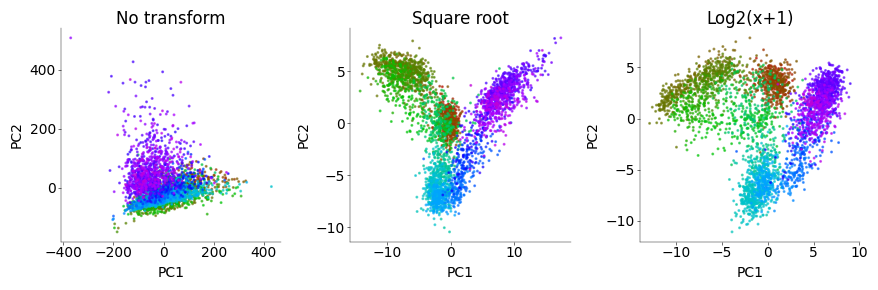

In [197]:
# ------------------------------------------------
# plot first 2 PCs for each transformation (1 pt)
# ------------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot
for ax, PCs, title in zip(
    axs, [PC_raw, PC_sqrt, PC_log], ["No transform", "Square root", "Log2(x+1)"]
):
    scatter = ax.scatter(
        PCs[:, 0], PCs[:, 1], c=clusterColors[clusters], s=5, alpha=0.6
    )
    ax.set_title(title)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

plt.tight_layout()
plt.show()

_Explanation (1 pt)_
...

- no transorm: wide dynamic range in PCA space; clusters appear compressed into a narrow band, with some long tails; strong influence of highly expressed genes that skew variance and most importantly poor separation of clusters: PCA picks up total count differences rather than meaningful structure
- square root transform: Clear improvement in cluster separation; Expression values are variance-stabilized for Poisson-distributed data (which scRNA-seq approximates);
some cluster overlap remains, but overall, this transformation seems to preserves structure better than raw counts
- log2(x + 1) Transform: best separation and compactness of clusters; enhances separability by compressing expression outliers and reducing skew; clusters appear well-formed and more isotropic (not stretched).

### 2.2. tSNE with and without transformations

Now, we will reduce the dimensionality of the PCA-reduced data further to two dimensions using t-SNE. We will use only $n=50$ components of the PCA-projected data. Plot the t-SNE embedding for the three versions of the data and interpret the plots. Do the different transformations have any effect on t-SNE?

_(1.5 pts)_

In [198]:
# -----------------------
# Perform tSNE (0.5 pts)
# -----------------------

# 50-component PCA for each dataset
pca = PCA(n_components=50)
PC_raw_50 = pca.fit_transform(X_raw)
PC_sqrt_50 = pca.fit_transform(X_sqrt)
PC_log_50 = pca.fit_transform(X_log)

from sklearn.manifold import TSNE

# t-SNE on each PCA-reduced dataset
tsne_raw = TSNE(n_components=2, random_state=42).fit_transform(PC_raw_50)
tsne_sqrt = TSNE(n_components=2, random_state=42).fit_transform(PC_sqrt_50)
tsne_log = TSNE(n_components=2, random_state=42).fit_transform(PC_log_50)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/1142298574.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


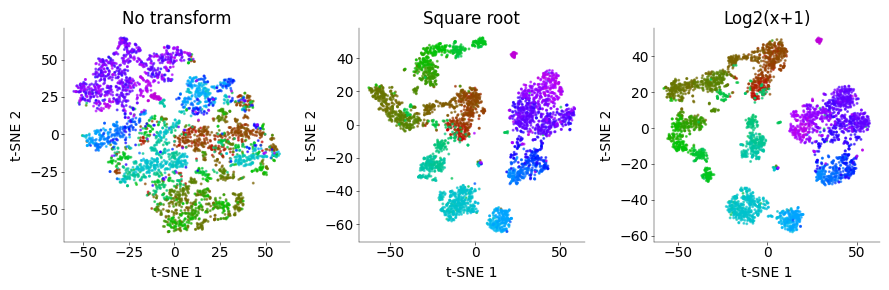

In [199]:
# -----------------------------------------------
# plot t-SNE embedding for each dataset (1 pt)
# -----------------------------------------------

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
# add plot

for ax, tsne, title in zip(
    axs, [tsne_raw, tsne_sqrt, tsne_log], ["No transform", "Square root", "Log2(x+1)"]
):
    ax.scatter(tsne[:, 0], tsne[:, 1], c=clusterColors[clusters], s=5, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

### 2.3. Leiden clustering

Now we will play around with some clustering and see whether the clustering methods can produce similar results to the original clusters from the publication. We will apply Leiden clustering (closely related to the Louvain clustering), which is standard in the field and works well even for very large datasets. 

Choose one representation of the data (best transformation based in your results from the previous task) to use further in this task and justify your choice. Think about which level of dimensionality would be sensible to use to perform clustering. Visualize in the two-dimensional embedding the resulting clusters and compare to the original clusters. 

_(1.5 pts)_

In [200]:
# To run this code you need to install leidenalg and igraph
# conda install -c conda-forge python-igraph leidenalg

import igraph as ig
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
import leidenalg as la

In [201]:
# Define some contrast colors

clusterCols = [
    "#FFFF00",
    "#1CE6FF",
    "#FF34FF",
    "#FF4A46",
    "#008941",
    "#006FA6",
    "#A30059",
    "#FFDBE5",
    "#7A4900",
    "#0000A6",
    "#63FFAC",
    "#B79762",
    "#004D43",
    "#8FB0FF",
    "#997D87",
    "#5A0007",
    "#809693",
    "#FEFFE6",
    "#1B4400",
    "#4FC601",
    "#3B5DFF",
    "#4A3B53",
    "#FF2F80",
    "#61615A",
    "#BA0900",
    "#6B7900",
    "#00C2A0",
    "#FFAA92",
    "#FF90C9",
    "#B903AA",
    "#D16100",
    "#DDEFFF",
    "#000035",
    "#7B4F4B",
    "#A1C299",
    "#300018",
    "#0AA6D8",
    "#013349",
    "#00846F",
    "#372101",
    "#FFB500",
    "#C2FFED",
    "#A079BF",
    "#CC0744",
    "#C0B9B2",
    "#C2FF99",
    "#001E09",
    "#00489C",
    "#6F0062",
    "#0CBD66",
    "#EEC3FF",
    "#456D75",
    "#B77B68",
    "#7A87A1",
    "#788D66",
    "#885578",
    "#FAD09F",
    "#FF8A9A",
    "#D157A0",
    "#BEC459",
    "#456648",
    "#0086ED",
    "#886F4C",
    "#34362D",
    "#B4A8BD",
    "#00A6AA",
    "#452C2C",
    "#636375",
    "#A3C8C9",
    "#FF913F",
    "#938A81",
    "#575329",
    "#00FECF",
    "#B05B6F",
    "#8CD0FF",
    "#3B9700",
    "#04F757",
    "#C8A1A1",
    "#1E6E00",
    "#7900D7",
    "#A77500",
    "#6367A9",
    "#A05837",
    "#6B002C",
    "#772600",
    "#D790FF",
    "#9B9700",
    "#549E79",
    "#FFF69F",
    "#201625",
    "#72418F",
    "#BC23FF",
    "#99ADC0",
    "#3A2465",
    "#922329",
    "#5B4534",
    "#FDE8DC",
    "#404E55",
    "#0089A3",
    "#CB7E98",
    "#A4E804",
    "#324E72",
    "#6A3A4C",
    "#83AB58",
    "#001C1E",
    "#D1F7CE",
    "#004B28",
    "#C8D0F6",
    "#A3A489",
    "#806C66",
    "#222800",
    "#BF5650",
    "#E83000",
    "#66796D",
    "#DA007C",
    "#FF1A59",
    "#8ADBB4",
    "#1E0200",
    "#5B4E51",
    "#C895C5",
    "#320033",
    "#FF6832",
    "#66E1D3",
    "#CFCDAC",
    "#D0AC94",
    "#7ED379",
    "#012C58",
]

clusterCols = np.array(clusterCols)

We use the log2(x+1)–transformed data from before, because it gave the clearest separation in both PCA and t-SNE plots.

In [202]:
# ------------------------------------------------------
# create graph and run leiden clustering on it (0.5 pts)
# hint: use `la?`, `la.find_partition?` and `ig.Graph?`
# to find out more about the provided packages.
# ------------------------------------------------------

# Construct kNN graph with k=15
from sklearn.neighbors import kneighbors_graph

A = kneighbors_graph(PC_log_50, n_neighbors=15, include_self=False)

# Transform it into an igraph object
# get graph edges
sources, targets = A.nonzero()

# Build igraph graph from kNN adjacency matrix
edges = list(zip(sources, targets))
g = ig.Graph(edges=edges, directed=False)

# Run Leiden clustering
# you can use `la.RBConfigurationVertexPartition` as the partition type
partition = la.find_partition(g, la.RBConfigurationVertexPartition)
leiden_labels = np.array(partition.membership)

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/1692669520.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


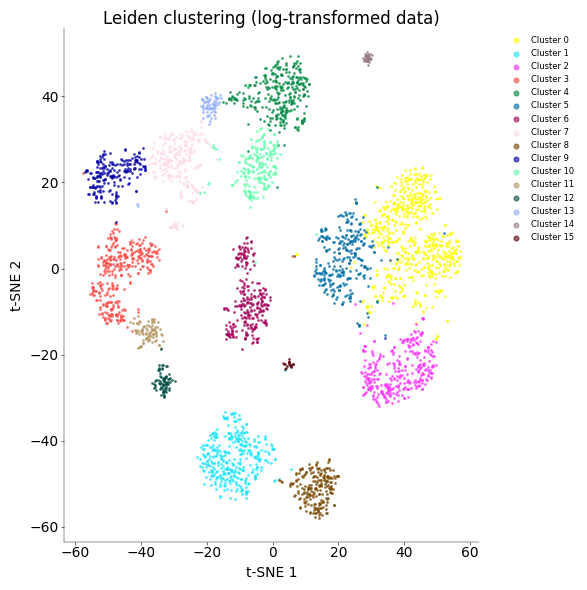

In [203]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, ax = plt.subplots(figsize=(6, 6))

n_clusters = len(np.unique(leiden_labels))
colors = clusterCols[:n_clusters]  # subset of the palette

for i in range(n_clusters):
    ax.scatter(
        tsne_log[leiden_labels == i, 0],
        tsne_log[leiden_labels == i, 1],
        s=5,
        color=colors[i],
        label=f"Cluster {i}",
        alpha=0.6,
    )

ax.set_title("Leiden clustering (log-transformed data)")
ax.set_xlabel("t-SNE 1")
ax.set_ylabel("t-SNE 2")
ax.legend(markerscale=3, fontsize=6, bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/1999693538.py:22: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


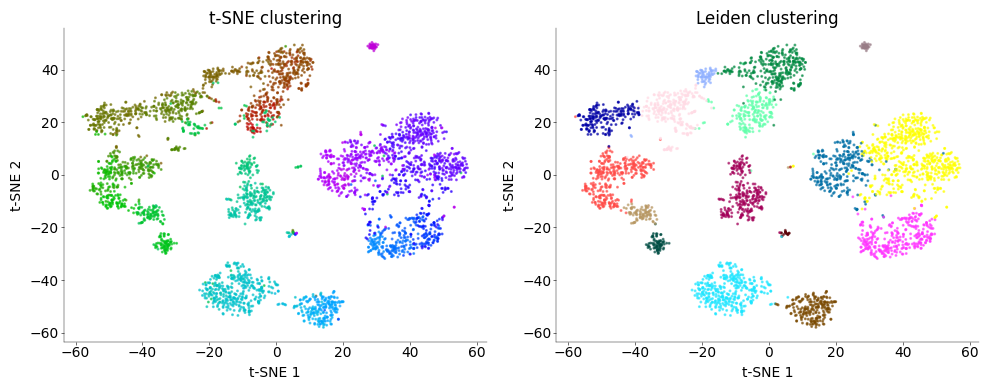

In [204]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# t-SNE clusters
axs[0].scatter(
    tsne_log[:, 0], tsne_log[:, 1], c=clusterColors[clusters], s=5, alpha=0.6
)
axs[0].set_title("t-SNE clustering")
axs[0].set_xlabel("t-SNE 1")
axs[0].set_ylabel("t-SNE 2")

# Leiden clustering result
n_clusters = len(np.unique(leiden_labels))
leiden_colors = clusterCols[:n_clusters]

axs[1].scatter(
    tsne_log[:, 0], tsne_log[:, 1], c=leiden_colors[leiden_labels], s=5, alpha=0.6
)
axs[1].set_title("Leiden clustering")
axs[1].set_xlabel("t-SNE 1")
axs[1].set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()

### 2.4. Change the clustering resolution

The number of clusters can be changed by modifying the resolution parameter. How many clusters did we get with the default value? Change the resolution parameter to yield 2x more and 2x fewer clusters
Plot all three results as t-SNE overlays (same as above).

_(1.5 pts)_

In [ ]:
# ------------------------------------------------------------------
# run the clustering for 3 different resolution parameters (0.5 pts)
# ------------------------------------------------------------------

# resolution values
resolutions = [0.5, 1.0, 2.0]
leiden_labels_all = []

# Leiden clustering for each resolution
for res in resolutions:
    partition = la.find_partition(
        g, la.RBConfigurationVertexPartition, resolution_parameter=res
    )

    # extract labels and store them
    labels = np.array(partition.membership)
    leiden_labels_all.append(labels)

    # print result
    n_clusters = len(np.unique(labels))
    print(f"Resolution {res}: {n_clusters} clusters")

Resolution 0.5: 12 clusters
Resolution 1.0: 17 clusters
Resolution 2.0: 22 clusters


/var/folders/d8/g4v8flv97mz27ttn1q5wfnn40000gn/T/ipykernel_2977/2806932493.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


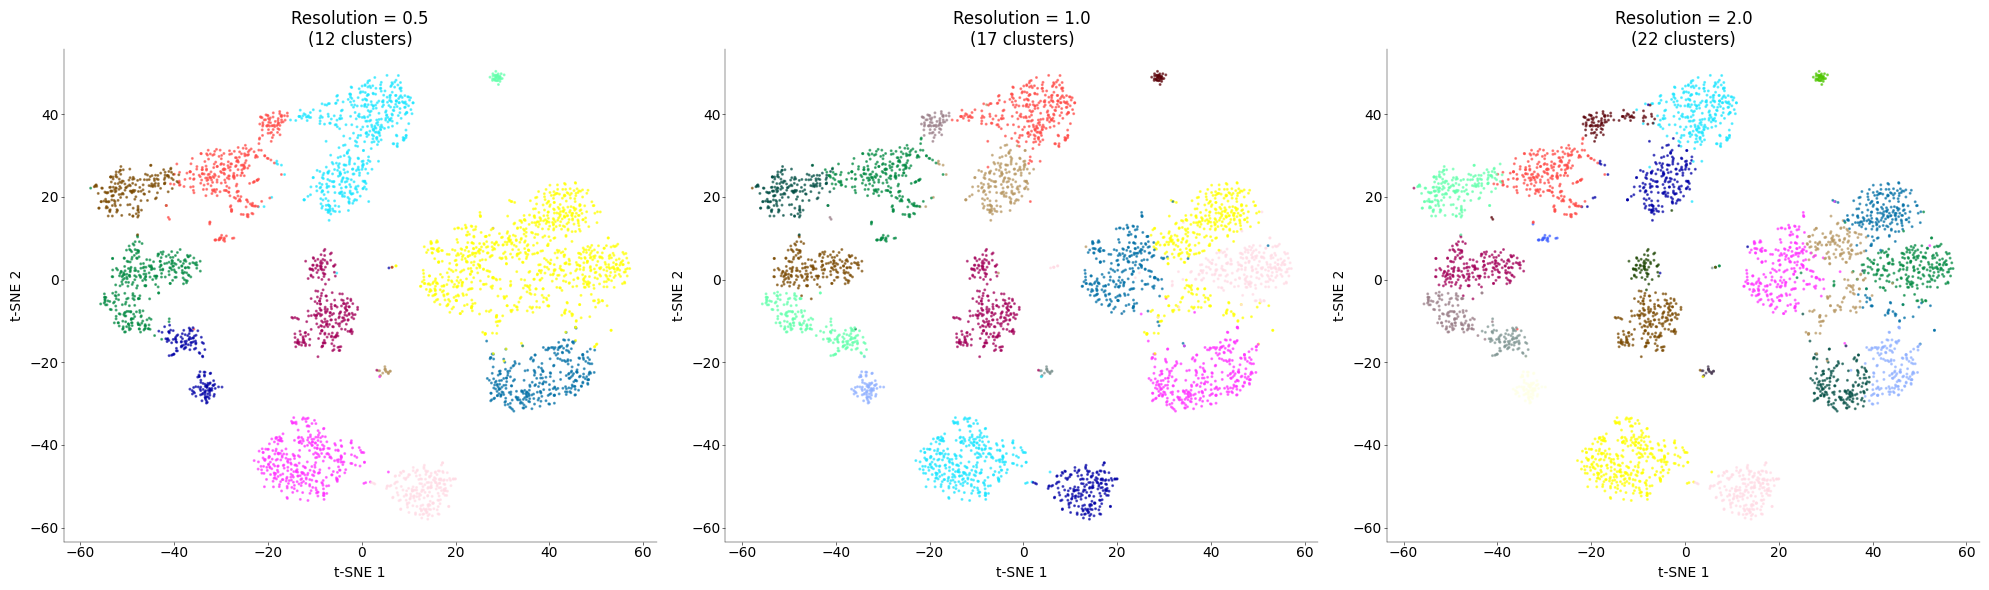

In [209]:
# --------------------------
# Plot the results (1 pt)
# --------------------------

fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# add plot
for ax, labels, res in zip(axs, leiden_labels_all, resolutions):
    n_clusters = len(np.unique(labels))
    colors = clusterCols[:n_clusters]

    ax.scatter(tsne_log[:, 0], tsne_log[:, 1], c=colors[labels], s=5, alpha=0.6)
    ax.set_title(f"Resolution = {res}\n({n_clusters} clusters)")
    ax.set_xlabel("t-SNE 1")
    ax.set_ylabel("t-SNE 2")

plt.tight_layout()
plt.show()